In [1]:
!pip install scikit-learn

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten,MaxPooling2D,BatchNormalization,Lambda, AveragePooling2D, Dropout, SpatialDropout2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [3]:
train_x = pd.read_csv(r"C:\Users\kbs77\coin\train_x_df.csv")
train_y = pd.read_csv(r"C:\Users\kbs77\coin\train_y_df.csv")
test_x = pd.read_csv(r"C:\Users\kbs77\coin\test_x_df.csv")
sample_submission = pd.read_csv(r"C:\Users\kbs77\coin\sample_submission.csv")

**iloc함수를 이용하여 첫 두 컬럼(sample_id, coin_index)을 제외하고 CNN모델에 적용하기 위해 reshape**

In [4]:
X_train = np.array(train_x.iloc[:,2:]).reshape(7661, 1380, len(train_x.columns)-2, 1) # > (#_sampleid, #_time, #_columns, 1)
X_test = np.array(test_x.iloc[:,2:]).reshape(535, 1380, len(test_x.columns)-2, 1) # > (#_sampleid, #_time, #_columns, 1)

price = (np.array(train_y['high']) + np.array(train_y['low']))/2 # high와 low의 중간값을 사용!
Y_train = price.reshape(7661, 120)
Y_train2 = Y_train.argmax(axis=1).astype(np.float32)
# Y_train2 = Y_train.argsort(axis=1)[:,-4:].astype(np.float32)

In [5]:
n=1

# X_train_slice_mean = np.zeros(7362*10).reshape(7362,1,10,1)
# for i in range(1380//n):
#     X_train_slice_mean = np.concatenate([X_train_slice_mean, X_train[:,i*n:(i+1)*n,:,:].mean(axis=1).reshape(7362,1,10,1)], axis=1)
# X_train_slice_mean = X_train_slice_mean[:,1:,:,:]

# X_test_slice_mean = np.zeros(529*10).reshape(529,1,10,1)
# for i in range(1380//n):
#     X_test_slice_mean = np.concatenate([X_test_slice_mean, X_test[:,i*n:(i+1)*n,:,:].mean(axis=1).reshape(529,1,10,1)], axis=1)
# X_test_slice_mean = X_test_slice_mean[:,1:,:,:]

# Y_train_slice_mean = np.zeros(7362).reshape(7362,1)
# for i in range(120//n):
#     Y_train_slice_mean = np.concatenate([Y_train_slice_mean, Y_train[:,i*n:(i+1)*n].mean(axis=1).reshape(7362,1)], axis=1)
# Y_train_slice_mean = Y_train_slice_mean[:,1:]

# Y_train2 = Y_train_slice_mean.argsort(axis=1)[:,-4:].astype(np.float32)

# print(X_train_slice_mean.shape)
# print(X_test_slice_mean.shape)
# print(Y_train_slice_mean.shape)
# print(Y_train2.shape)

# X_train = X_train_slice_mean.copy()
# X_test = X_test_slice_mean.copy()

In [6]:
def my_loss(y_true, y_pred):
    result = (y_pred-y_true)
    return K.mean(K.square(result))

**keras 이용해서 CNN 모델 쌓기**

**nf = 16 ( 16개의 필터를 적용하겠다. )**

**fs = (3,1) ( (3,1)사이즈의 필터를 사용하겠다. )**

In [24]:
X_train.shape[1],X_train.shape[2],X_train.shape[3]
# 얘가 input_data

(1380, 10, 1)

In [7]:
def set_model(): 
    
    activation = 'elu'
    padding = 'valid'
    model = Sequential()
    nf = 16
    fs = (3,1)
    model.add(Conv2D(nf,fs, padding=padding, activation=activation,input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3]))) # 1300, 10, 1
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1))) # 650, 10, 16

    model.add(Conv2D(nf*2,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1))) # 325, 10, 32

    model.add(Conv2D(nf*4,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1))) #  162, 10, 64

    model.add(Conv2D(nf*8,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1))) #  81, 10 ,128

    model.add(Conv2D(nf*16,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1))) #  40, 10 ,256

    model.add(Conv2D(nf*32,fs, padding=padding, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 1))) #  20, 10 ,512


    
    model.add(Flatten()) 
    model.add(Dense(512, activation ='elu')) 
    model.add(Dense(128, activation ='elu')) 
    model.add(Dense(32, activation ='elu')) 
    model.add(Dense(8, activation ='elu')) 
    model.add(Dense(4, activation ='elu')) 
    model.add(Dense(1))# output size 

    optimizer = keras.optimizers.Adam(learning_rate=1e-06)

    model.compile(loss=my_loss,
              optimizer=optimizer,)

    return model

In [9]:
def train(model, X, Y, is_val=False):
    MODEL_SAVE_FOLDER_PATH = './model/'
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
        os.mkdir(MODEL_SAVE_FOLDER_PATH)

    model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'
    best_save = ModelCheckpoint('best_m.hdf5', save_best_only=True, monitor='val_loss', mode='min')

    if is_val == False:
        history = model.fit(X, Y,
                      epochs=150,
                      batch_size=512,
                      shuffle=True,
                      validation_split=0.2,
                      verbose = 1,
                      callbacks=[best_save])

        fig, loss_ax = plt.subplots()
        acc_ax = loss_ax.twinx()

        loss_ax.plot(history.history['loss'], 'y', label='train loss')
        loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        loss_ax.legend(loc='upper left')
        plt.show()    
        
#     else:
#         history = model.fit(X, Y,
#                       epochs=30,
#                       batch_size=256,
#                       shuffle=True,
#                       validation_split=0.2,
#                       verbose = 1,
#                       callbacks=[best_save])
    
    return model

In [10]:
def load_best_model():
    model = load_model('best_m.hdf5' ,custom_objects={'my_loss': my_loss, })
    score = model.evaluate(X_train, Y_train2, verbose=0) 
    print('loss:', score)
    return model

Epoch 1/150
12/12 [==============================] - 344s 29s/step - loss: 4658.4852 - val_loss: 4580.2700
Epoch 2/150
12/12 [==============================] - 344s 29s/step - loss: 4467.4493 - val_loss: 4556.0151
Epoch 3/150
12/12 [==============================] - 347s 29s/step - loss: 4480.5546 - val_loss: 4541.2129
Epoch 4/150
12/12 [==============================] - 341s 28s/step - loss: 4396.5656 - val_loss: 4525.6792
Epoch 5/150
12/12 [==============================] - 346s 29s/step - loss: 4430.8254 - val_loss: 4508.4595
Epoch 6/150
12/12 [==============================] - 351s 29s/step - loss: 4446.9041 - val_loss: 4489.3330
Epoch 7/150
12/12 [==============================] - 349s 29s/step - loss: 4473.7438 - val_loss: 4469.0249
Epoch 8/150
12/12 [==============================] - 347s 29s/step - loss: 4509.8434 - val_loss: 4448.4297
Epoch 9/150
12/12 [==============================] - 358s 30s/step - loss: 4380.3034 - val_loss: 4428.6235
Epoch 10/150
12/12 [=================

Epoch 77/150
12/12 [==============================] - 367s 30s/step - loss: 4504.3576 - val_loss: 4325.4487
Epoch 78/150
12/12 [==============================] - 368s 31s/step - loss: 4427.9621 - val_loss: 4325.4336
Epoch 79/150
12/12 [==============================] - 370s 31s/step - loss: 4379.0398 - val_loss: 4325.4170
Epoch 80/150
12/12 [==============================] - 383s 32s/step - loss: 4516.7475 - val_loss: 4325.4014
Epoch 81/150
12/12 [==============================] - 374s 31s/step - loss: 4426.4340 - val_loss: 4325.3862
Epoch 82/150
12/12 [==============================] - 376s 32s/step - loss: 4497.5882 - val_loss: 4325.3726
Epoch 83/150
12/12 [==============================] - 374s 31s/step - loss: 4481.3597 - val_loss: 4325.3579
Epoch 84/150
12/12 [==============================] - 372s 31s/step - loss: 4361.9447 - val_loss: 4325.3442
Epoch 85/150
12/12 [==============================] - 378s 32s/step - loss: 4414.4788 - val_loss: 4325.3306
Epoch 86/150
12/12 [========

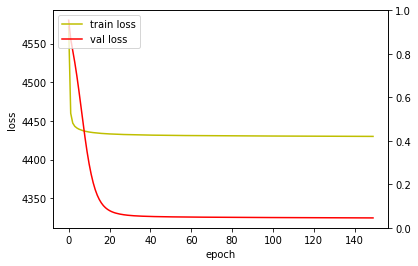

Wall time: 14h 57min 35s


In [12]:
%%time

np.random.seed(42)
model = set_model()
train(model, X_train, Y_train2, is_val=False)

In [15]:
best_model = load_best_model()
pred = best_model.predict(X_test)
pred[:5]

loss: 4408.9853515625


array([[2.652875 ],
       [2.6530643],
       [2.6529765],
       [2.6509233],
       [2.6524615]], dtype=float32)

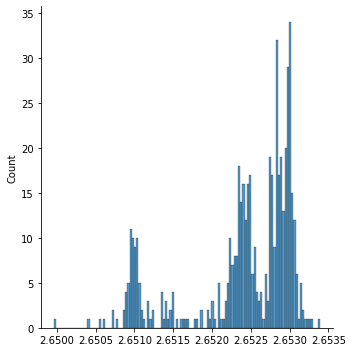

In [16]:
sns.displot(pred[:,0], bins=120)
# sns.displot(list(map(round, pred.argmax(axis=1))))

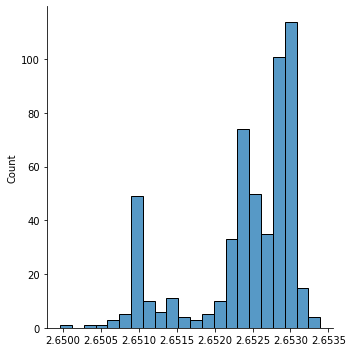

In [17]:
sns.displot(pred[:,0])

In [35]:
cutline1 = np.quantile(pred[:,0], 0.62)
cutline2 = np.quantile(pred[:,0], 0.67)
print(cutline1)
print(cutline2)
cutline3 = np.quantile(pred[:,0], [0.1, 0.62, 0.67, 0.99])
print(cutline3)

2.652825889587402
2.652852272987366
[2.65103154 2.65282589 2.65285227 2.65317567]


In [19]:
pred_var = np.var(pred, axis=1)
sample_submission['buy_quantity']=1
sample_submission['sell_time'] = list(map(lambda x: 0 if x <= cutline1 else (round(x) if x <= cutline2 else 119), pred[:,0]))
# sample_submission['buy_quantity'][sample_submission['sell_time']==1] = 0
sample_submission.to_csv("submission.csv", index=False)

In [20]:
Counter(sample_submission['sell_time'])

Counter({119: 177, 0: 332, 3: 26})

In [21]:
print(sample_submission['buy_quantity'].nunique())
print(sample_submission['sell_time'].nunique())

1
3
